# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## How you can use this notebook

You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.

Why?

Because there are many different ways (actually, there's almost an infinite number of ways) to write neural networks.

But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputing some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

Okay, enough talk, let's get started writing code.

To use TensorFlow, we'll import it as the common alias `tf` (short for TensorFlow).

In [1]:
# Import Tensorflow
import tensorflow as tf
print(tf.__version__)

2.12.0


## Create data to view and fit

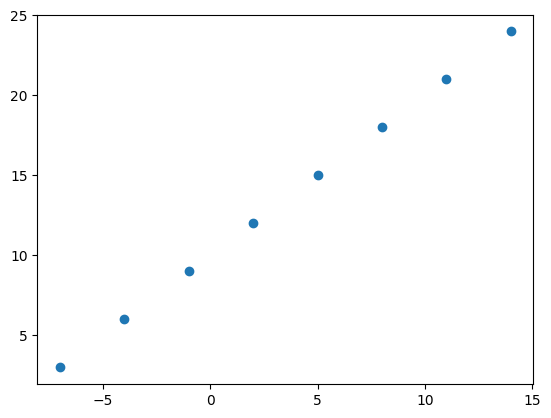

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y)

In [3]:
y == X +10

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Input and output shapes

In [4]:
# Create a demo tensor for a housing price prediction problem
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [5]:
X[0], y[0]

(-7.0, 3.0)

In [6]:
input_shape = X[0].shape
output_shape = y[0].shape
input_shape, output_shape

((), ())

In [7]:
X[0].ndim

0

In [8]:
# Turn our NumPy array into Tensors with dtype float32
X = tf.cast(tf.constant(X), dtype=tf.float32)
y = tf.cast(tf.constant(y), dtype=tf.float32)
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [9]:
input_shape = X[0].shape
out_shape = y[0].shape
input_shape, out_shape

(TensorShape([]), TensorShape([]))

## Steps in modelling with TensorFlow

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - Define the input and output layes, as well as the hidden layers of a deep learning model. piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a models performance should be measured (**loss**(the function which tells our model how wrong it is)/**metrics**(what we can use to interpret the performance of our model)) as well as defining how it should improve (**optimizer**(tell our model how to improve the patterns its learning)). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 

Let's see these in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for our regression data. And then we'll step through each.

> **Note:** If you're using [TensorFlow 2.7.0](https://github.com/tensorflow/tensorflow/releases/tag/v2.7.0)+, the `fit()` function no longer upscales input data to go from `(batch_size, )` to `(batch_size, 1)`. To fix this, you'll need to expand the dimension of input data using `tf.expand_dims(input_data, axis=-1)`.
>
> In our case, this means instead of using `model.fit(X, y, epochs=5)`, use `model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)`. 

In [10]:
# Set random seed
tf.random.set_seed(42)

# 1- Create a model using the sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2- Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# model.fit(X, y, epochs=5) # this will break with TensorFlow 2.7.0+
model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)

Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 8.5180 - mae: 8.5180
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 8.3855 - mae: 8.3855
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 8.2530 - mae: 8.2530
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 8.1205 - mae: 8.1205
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 7.9880 - mae: 7.9880


**epochs-- how many times the model will go through all of the training examples**

In [11]:
# Check out X and  y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [12]:
# Try and make a prediction using our model
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 141ms/step


array([[27.223507]], dtype=float32)

## Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model**:

  1-1- here you might want to add more layers, 

  1-2- increase the number of hidden units (also called neurons) within each layer, 

  1-3- change the activation functions of each layer.
2. **Compiling a model**:

 2-1- you might want to choose optimization function 

 2-2- perhaps change the **learning rate** of the optimization function.
3. **Fitting a model**:

 3-1- perhaps you could fit a model for more **epochs** (leave it training for longer) 
 
  3-2- or on more data (give the model more examples to learn from).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Woah. We just introduced a bunch of possible steps. The important thing to remember is how you alter each of these will depend on the problem you're working on.

And the good thing is, over the next few problems, we'll get hands-on with all of them.

For now, let's keep it simple, all we'll do is train our model for longer (everything else will stay the same).

In [13]:
# Let's rebuild our model

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=-1), y, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 874ms/step - loss: 18.8762 - mae: 18.8762
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 18.5949 - mae: 18.5949
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 18.3137 - mae: 18.3137
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 18.0324 - mae: 18.0324
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 17.7512 - mae: 17.7512
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 17.4699 - mae: 17.4699
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 17.1887 - mae: 17.1887
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 16.9074 - mae: 16.9074
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 16.6262 - mae: 16.6262
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 16.3449 - mae: 16.3449
Epoch 11/100
1/1 [==============================

In [14]:
# Remind ourselves of the data
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [15]:
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 73ms/step


array([[29.552864]], dtype=float32)

In [16]:
from keras import optimizers
# Let's see if we can make another to improve model

# 1. Create the model ()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation=None),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=-1), y, epochs=100)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 13.5623 - mae: 13.5623
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 12.8876 - mae: 12.8876
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 12.2096 - mae: 12.2096
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 11.5269 - mae: 11.5269
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 10.8376 - mae: 10.8376
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 10.1394 - mae: 10.1394
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 9.4299 - mae: 9.4299
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 8.7067 - mae: 8.7067
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 7.9674 - mae: 7.9674
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 7.2093 - mae: 7.2093
Epoch 11/100
1/1 [==============================] - 0s 21ms

In [17]:
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 209ms/step


array([[26.580597]], dtype=float32)

## Evaluating a model 

A typical workflow you'll go through when building neural networks is:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

The tweaking comes from maybe not building a model from scratch but adjusting an existing one.

### Visualize, visualize, visualize

When it comes to evaluation, you'll want to remember the words: "visualize, visualize, visualize." 

This is because you're probably better looking at something (doing) than you are thinking about something.

It's a good idea to visualize:
* **The data** - what data are you working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of a model** - how does a model perform while it learns?
* **The predictions of a model** - how do the predictions of a model line up against the ground truth (the original labels)?

Let's start by visualizing the model.

But first, we'll create a little bit of a bigger dataset and a new model we can use (it'll be the same as before, but the more practice the better).


In [18]:
# Make a bigger data
X = tf.range(-100, 100, 4)
X

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96], dtype=int32)>

In [19]:
# Make labels for the dataset
y = X + 10
y

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>

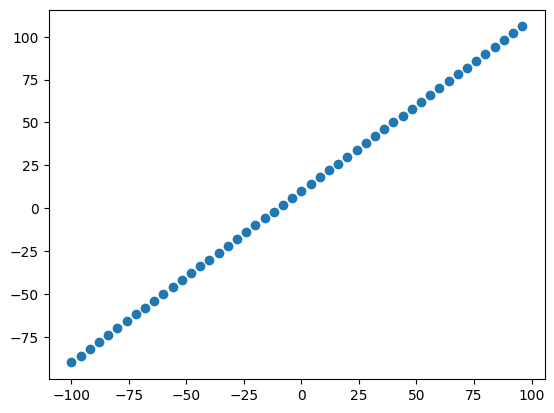

In [20]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(X, y)

## Split data into training/test set

One of the other most common and important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each set serves a specific purpose:
* **Training set** - the model learns from this data, which is typically 70-80% of the total data available (like the course materials you study during the semester).
* **Validation set** - the model gets tuned on this data, which is typically 10-15% of the total data available (like the practice exam you take before the final exam).
* **Test set** - the model gets evaluated on this data to test what it has learned, it's typically 10-15% of the total data available (like the final exam you take at the end of the semester).

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` arrays.

> 🔑 **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [21]:
# Check how many samples we have
len(X)

50

In [22]:
# Split the data into train and test sets
X_train = X[:40] # first 40 are trainingsamples (80% of the data)
y_train = y[:40]

X_test = X[40:] # Last 10 are testing samples (20% of the data)
y_test = y[40:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

## Visualizing the data

Now we've got our training and test data, it's a good idea to visualize it.

Let's plot it with some nice colours to differentiate what's what.

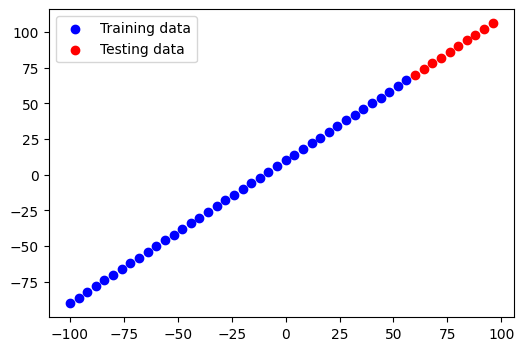

In [23]:
plt.figure(figsize=(6, 4))
# Plot training data in blue
plt.scatter(X_train, y_train, c="b", label="Training data")
# Plot testing data in red
plt.scatter(X_test, y_test, c="r", label="Testing data")
plt.legend();

Beautiful! Any time you can visualize your data, your model, your anything, it's a good idea. 

With this graph in mind, what we'll be trying to do is build a model which learns the pattern in the blue dots (`X_train`) to draw the green dots (`X_test`).

Time to build a model. We'll make the exact same one from before (the one we trained for longer).

In [24]:
# Let's have a look at how to build a neural network for our data

# 1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# # 3. Fit the model
# model.fit(X_train, y_train, epochs=100)

## Visualizing the model

After you've built a model, you might want to take a look at it (especially if you haven't built many before).

You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it.

> 🔑 **Note:** Visualizing a model is particularly helpful when you run into input and output shape mismatches.

In [26]:
model.summary()

ValueError: ignored

Ahh, the cell above errors because we haven't fit our built our model.

We also haven't told it what input shape it should be expecting.

Remember above, how we discussed the input shape was just one number?

We can let our model know the input shape of our data using the `input_shape` parameter to the first layer (usually if `input_shape` isn't defined, Keras tries to figure it out automatically).

In [27]:
# Let's create a model which builds automatically by defining the input shape atgument
tf.random.set_seed(42)

# 1. Create a model (same as above)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[1], name="input_layer"),
    tf.keras.layers.Dense(1, name="output_layer")
], name="model_1")

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
             optimizer=tf.keras.optimizers.SGD(),
             metrics=["mae"])

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 10)                20        
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.
* **Total params** - total number of parameters in the model.
* **Trainable parameters** - these are the parameters (patterns) the model can update as it trains.
* **Non-trainable parameters** - these parameters aren't updated during training (this is typical when you bring in the already learned patterns from other models during transfer learning).

> 📖 **Resource:** For a more in-depth overview of the trainable parameters within a layer, check out [MIT's introduction to deep learning video](https://youtu.be/njKP3FqW3Sk).

> 🛠 **Exercise:** Try playing around with the number of hidden units in the `Dense` layer (e.g. `Dense(2)`, `Dense(3)`). How does this change the Total/Trainable params? Investigate what's causing the change.

For now, all you need to think about these parameters is that their learnable patterns in the data.

Let's fit our model to the training data.

In [29]:
# Let's fit the model to the training data

# 3. Fit the model
model.fit(X_train, y_train, epochs=100, verbose=0)

In [30]:
# Get a summary of our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 10)                20        
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


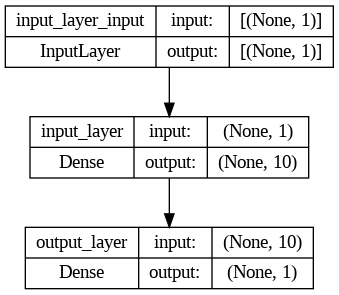

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model=model, show_shapes=True)

## Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.

To visualize predictions, it's always a good idea to plot them against the ground truth labels.

Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.

In [32]:
# Make some predictions 
y_pred = model.predict(X_test)
y_pred

1/1 [==============================] - 0s 67ms/step


array([[ 70.55078 ],
       [ 75.138596],
       [ 79.72641 ],
       [ 84.314224],
       [ 88.90204 ],
       [ 93.489845],
       [ 98.07766 ],
       [102.66548 ],
       [107.25329 ],
       [111.841095]], dtype=float32)

In [33]:
y_test

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>

**Note:** If you feel like you're going to reuse some kind of functionality in the future, it's a good idea to turn into a function.

In [34]:
# Let's create a plotting function
def plot_predictions(train_data=X_train, 
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=y_pred):
  """
  Plots training data, test data and compares predictions to ground truth.
  """
  plt.figure(figsize=(10, 7))
  # Plot trainingdata in blue
  plt.scatter(train_data, train_labels, c="b", label="Training data")
  # Plot testing data in green
  plt.scatter(test_data, test_labels, c="g", label="Testing data")
  # Plot models predictions in red
  plt.scatter(test_data, predictions, c="r", label="Predictions")
  # Show the legend
  plt.legend();

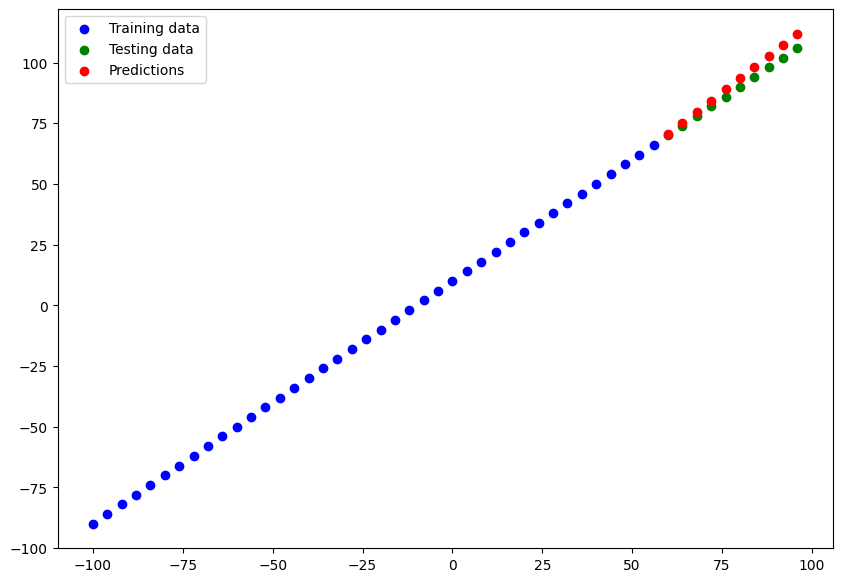

In [35]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_pred)

## Evaluating predictions

Alongisde visualizations, evaulation metrics are your alternative best option for evaluating your model.

Depending on the problem you're working on, different models have different evaluation metrics. 

Two of the main metrics used for regression problems are:
* **Mean absolute error (MAE)** - the mean difference between each of the predictions.
* **Mean squared error (MSE)** - the squared mean difference between of the predictions (use if larger errors are more detrimental than smaller errors).

The lower each of these values, the better.

You can also use [`model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) which will return the loss of the model as well as any metrics setup during the compile step.

In [36]:
# Evaluate the model pd the test
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 176ms/step - loss: 3.1959 - mae: 3.1959


[3.195941925048828, 3.195941925048828]

In [37]:
y_pred

array([[ 70.55078 ],
       [ 75.138596],
       [ 79.72641 ],
       [ 84.314224],
       [ 88.90204 ],
       [ 93.489845],
       [ 98.07766 ],
       [102.66548 ],
       [107.25329 ],
       [111.841095]], dtype=float32)

In [38]:
y_test

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>

In [39]:
# Calculate the mean absolute error
mae = tf.metrics.mean_absolute_error(y_true=y_test,
                                     y_pred=tf.constant(y_pred)) 
mae

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([17.559376, 14.116842, 11.709436, 10.337155, 10.      , 10.697969,
       12.446596, 15.332385, 19.253288, 23.841095], dtype=float32)>

In [40]:
tf.constant(y_pred)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 70.55078 ],
       [ 75.138596],
       [ 79.72641 ],
       [ 84.314224],
       [ 88.90204 ],
       [ 93.489845],
       [ 98.07766 ],
       [102.66548 ],
       [107.25329 ],
       [111.841095]], dtype=float32)>

Remember how we discussed dealing with different input and output shapes is one the most common issues you'll come across, this is one of those times.

But not to worry.

We can fix it using [`squeeze()`](https://www.tensorflow.org/api_docs/python/tf/squeeze), it'll remove the the `1` dimension from our `y_preds` tensor, making it the same shape as `y_test`.

> 🔑 **Note:** If you're comparing two tensors, it's important to make sure they're the right shape(s) (you won't always have to manipulate the shapes, but always be on the look out, *many* errors are the result of mismatched tensors, especially mismatched input and output shapes).

In [41]:
tf.squeeze(y_pred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 70.55078 ,  75.138596,  79.72641 ,  84.314224,  88.90204 ,
        93.489845,  98.07766 , 102.66548 , 107.25329 , 111.841095],
      dtype=float32)>

In [42]:
# Calculate the mean absolute error 
mae = tf.metrics.mean_absolute_error(y_true=y_test,
                                     y_pred=tf.squeeze(y_pred))
mae

<tf.Tensor: shape=(), dtype=float32, numpy=3.195942>

In [43]:
# Calculate the MSE
mse = tf.metrics.mean_squared_error(y_true=y_test,
                                    y_pred=tf.squeeze(y_pred))
mse

<tf.Tensor: shape=(), dtype=float32, numpy=13.064619>

In [44]:
# Make some functions to use MAE and MSE
def mae(y_true, y_pred):
  """
  calculate the MAE of y_true and y_pred.
  """
  return tf.metrics.mean_absolute_error(y_true=y_true, 
                                        y_pred=tf.squeeze(y_pred))

def mse(y_true, y_pred):
  """
  calculate the MSE of y_true and y_pred.
  """
  return tf.metrics.mean_squared_error(y_true=y_true, 
                                       y_pred=tf.squeeze(y_pred))

In [45]:
mae(y_test, y_pred).numpy(), mse(y_test, y_pred).numpy()

(3.195942, 13.064619)

## Running experiments to improve a model

After seeing the evaluation metrics and the predictions your model makes, it's likely you'll want to improve it.

Again, there are many different ways you can do this, but 3 of the main ones are:
1. **Get more data** - get more examples for your model to train on (more opportunities to learn patterns).
2. **Make your model larger (use a more complex model)** - this might come in the form of more layers or more hidden units in each layer.
3. **Train for longer** - give your model more of a chance to find the patterns in the data.

Since we created our dataset, we could easily make more data but this isn't always the case when you're working with real-world datasets.

So let's take a look at how we can improve our model using 2 and 3.

To do so, we'll build 3 models and compare their results:
1. `model_1` - same as original model, 1 layer, trained for 100 epochs.
2. `model_2` - 2 layers, trained for 100 epochs.
3. `model_3` - 2 layers, trained for 500 epochs.

**Build `model_1`**

In [46]:
X_train.shape, y_train.shape

(TensorShape([40]), TensorShape([40]))

In [47]:
X_train.ndim, y_train.ndim

(1, 1)

In [48]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"])

# 3. Fit the model_1
model_1.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 15ms/step - loss: 8.5200 - mae: 8.5200
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 10.3390 - mae: 10.3390
Epoch 3/100
2/2 [==============================] - 0s 9ms/step - loss: 10.7143 - mae: 10.7143
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 9.5300 - mae: 9.5300
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 10.4347 - mae: 10.4347
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 9.6645 - mae: 9.6645
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 8.7655 - mae: 8.7655
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 9.0559 - mae: 9.0559
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 19.2493 - mae: 19.2493
Epoch 10/100
2/2 [==============================] - 0s 7ms/step - loss: 10.3875 - mae: 10.3875
Epoch 11/100
2/2 [==============================] - 0s 11ms/step - l

1/1 [==============================] - 0s 42ms/step


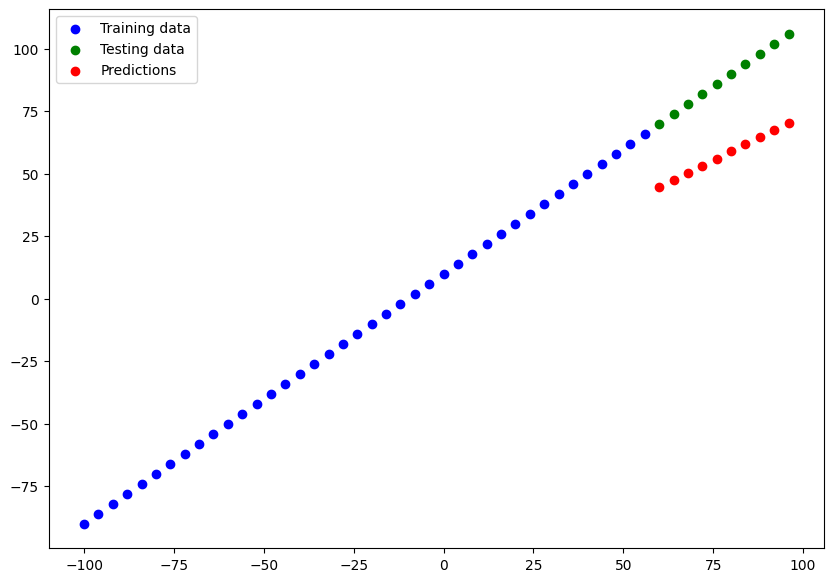

In [49]:
# Make and plot predictions for model 1
y_preds_1 = model_1.predict(X_test)
plot_predictions(predictions=y_preds_1)

In [50]:
tf.constant(y_preds_1), tf.squeeze(y_preds_1)

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[44.51664 ],
        [47.397583],
        [50.278526],
        [53.15947 ],
        [56.040413],
        [58.921356],
        [61.802296],
        [64.68324 ],
        [67.564186],
        [70.44512 ]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([44.51664 , 47.397583, 50.278526, 53.15947 , 56.040413, 58.921356,
        61.802296, 64.68324 , 67.564186, 70.44512 ], dtype=float32)>)

In [51]:
# Calculate model_1 evaluation metrics
mae_1 = mae(y_test, y_preds_1)
mse_1 = mse(y_test, y_preds_1)
mae_1, mse_1

(<tf.Tensor: shape=(), dtype=float32, numpy=30.519115>,
 <tf.Tensor: shape=(), dtype=float32, numpy=941.74786>)

**Build `model_2`**

This time we'll add an extra dense layer (so now our model will have 2 layers) whilst keeping everything else the same.

In [52]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mse"])

# 3. Fit the model
model_2.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 12ms/step - loss: 49.7679 - mse: 3536.2161
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 35.7290 - mse: 1780.4514
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 39.7557 - mse: 2383.4912
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 27.2240 - mse: 1076.8477
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 14.8809 - mse: 276.7150
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 11.8652 - mse: 166.5393
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 12.9721 - mse: 233.6140
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 11.1622 - mse: 162.7052
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 41.0121 - mse: 2661.9402
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 28.3358 - mse: 1132.5497
Epoch 11/100
2/2 [========================

1/1 [==============================] - 0s 46ms/step


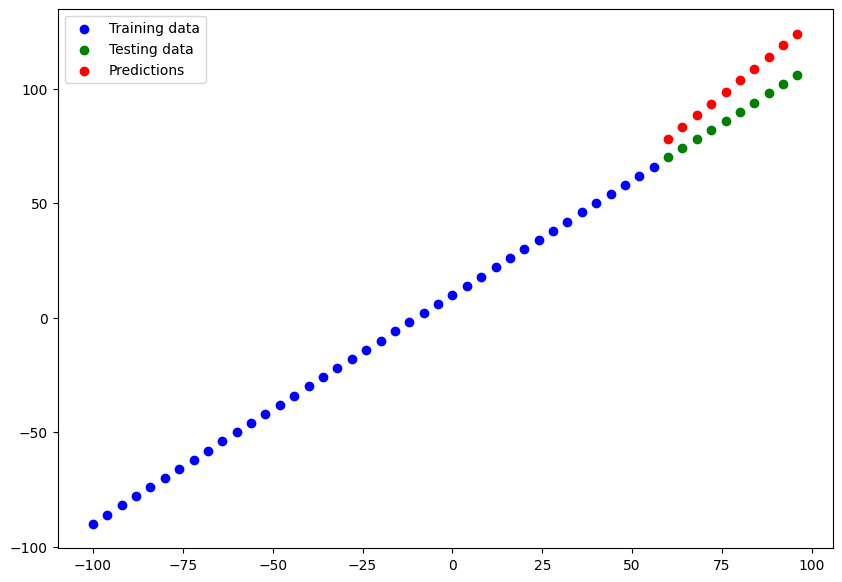

In [53]:
# Make and plot predictions of model 2
y_preds_2 = model_2.predict(X_test)
plot_predictions(predictions=y_preds_2)

In [54]:
# Calculate model_2 evaluation metrics
mae_2 = mae(y_test, y_preds_2)
mse_2 = mse(y_test, y_preds_2)
mae_2, mse_2

(<tf.Tensor: shape=(), dtype=float32, numpy=13.094156>,
 <tf.Tensor: shape=(), dtype=float32, numpy=181.36777>)

In [55]:
# Calculate model_1 evaluation metrics
mae_1 = mae(y_test, y_preds_1)
mse_1 = mse(y_test, y_preds_1)
mae_1, mse_1

(<tf.Tensor: shape=(), dtype=float32, numpy=30.519115>,
 <tf.Tensor: shape=(), dtype=float32, numpy=941.74786>)

**Build `model_3`**

For our 3rd model, we'll keep everything the same as `model_2` except this time we'll train for longer (500 epochs instead of 100).

This will give our model more of a chance to learn the patterns in the data.

In [56]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"]
                )

# 3. Fit the model
model_3.fit(tf.expand_dims(X_train, axis=-1), y_train, epochs=500)

Epoch 1/500
2/2 [==============================] - 0s 12ms/step - loss: 38.8158 - mae: 38.8158
Epoch 2/500
2/2 [==============================] - 0s 6ms/step - loss: 30.4510 - mae: 30.4510
Epoch 3/500
2/2 [==============================] - 0s 6ms/step - loss: 28.3075 - mae: 28.3075
Epoch 4/500
2/2 [==============================] - 0s 6ms/step - loss: 15.9904 - mae: 15.9904
Epoch 5/500
2/2 [==============================] - 0s 6ms/step - loss: 22.2860 - mae: 22.2860
Epoch 6/500
2/2 [==============================] - 0s 6ms/step - loss: 10.9322 - mae: 10.9322
Epoch 7/500
2/2 [==============================] - 0s 6ms/step - loss: 11.9495 - mae: 11.9495
Epoch 8/500
2/2 [==============================] - 0s 6ms/step - loss: 10.8891 - mae: 10.8891
Epoch 9/500
2/2 [==============================] - 0s 7ms/step - loss: 37.4984 - mae: 37.4984
Epoch 10/500
2/2 [==============================] - 0s 7ms/step - loss: 25.1650 - mae: 25.1650
Epoch 11/500
2/2 [==============================] - 0s 12m

1/1 [==============================] - 0s 69ms/step


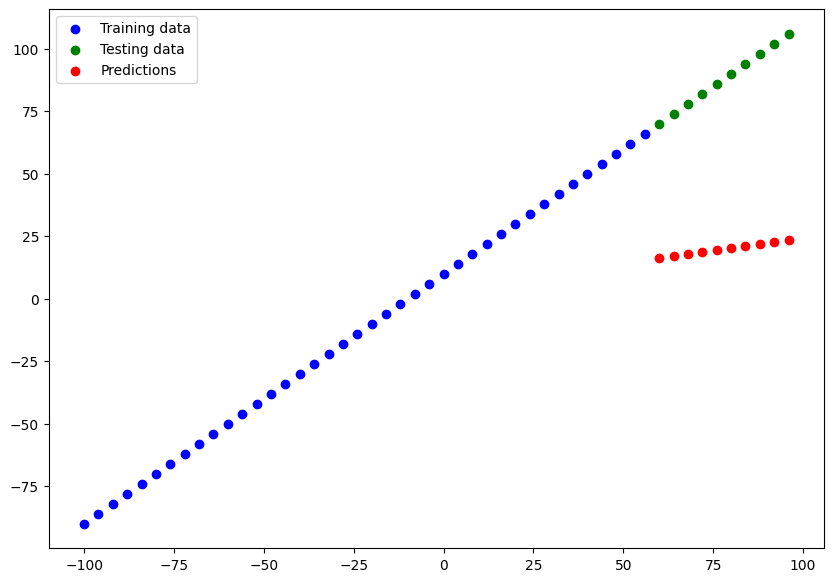

In [57]:
# Make and plot some predictions
y_preds_3 = model_3.predict(X_test)
plot_predictions(predictions=y_preds_3)

In [58]:
# Calculate mode_3 evaluation metrics
mae_3 = mae(y_test, y_preds_3)
mse_3 = mse(y_test, y_preds_3)
mae_3, mse_3

(<tf.Tensor: shape=(), dtype=float32, numpy=68.14019>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4728.0244>)

## Comparing results

Now we've got results for 3 similar but slightly different results, let's compare them.

In [60]:
# Let's compare our models result using a pandas DataFrame
import pandas as pd

model_results = [["model_1", mae_1.numpy(), mse_1.numpy()],
                 ["model_2", mae_2.numpy(), mse_2.numpy()],
                 ["model_3", mae_3.numpy(), mse_3.numpy()]]

all_results = pd.DataFrame(model_results, columns=["model", "mae", "mse"])
all_results

,model,mae,mse
0,model_1,30.519115,941.747864
1,model_2,13.094156,181.367767
2,model_3,68.140190,4728.024414


In [62]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                40        
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


From our experiments, it looks like `model_2` performed the best.

And now, you might be thinking, "wow, comparing models is tedious..." and it definitely can be, we've only compared 3 models here. 

But this is part of what machine learning modelling is about, trying many different combinations of models and seeing which performs best.

Each model you build is a small experiment. 

> 🔑 **Note:** One of your main goals should be to minimize the time between your experiments. The more experiments you do, the more things you'll figure out which don't work and in turn, get closer to figuring out what does work. Remember the machine learning practitioner's motto: "experiment, experiment, experiment".

Another thing you'll also find is what you thought may work (such as training a model for longer) may not always work and the exact opposite is also often the case.

## Tracking your experiments

One really good habit to get into is tracking your modelling experiments to see which perform better than others.

We've done a simple version of this above (keeping the results in different variables).

> 📖 **Resource:** But as you build more models, you'll want to look into using tools such as:
* [**TensorBoard**](https://tensorboard.dev/) - a component of the TensorFlow library to help track modelling experiments (we'll see this later).
* [**Weights & Biases**](https://www.wandb.com/) - a tool for tracking all kinds of machine learning experiments (the good news for Weights & Biases is it plugs into TensorBoard).

## Saving a model

Once you've trained a model and found one which performs to your liking, you'll probably want to save it for use elsewhere (like a web application or mobile device).

You can save a TensorFlow/Keras model using [`model.save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model).

There are two ways to save a model in TensorFlow:
1. The [SavedModel format](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) (default).
2. The [HDF5 format](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format).

The main difference between the two is the SavedModel is automatically able to save custom objects (such as special layers) without additional modifications when loading the model back in.

Which one should you use?

It depends on your situation but the SavedModel format will suffice most of the time.

Both methods use the same method call.

In [63]:
# Save the model using SaveModel format
model_2.save("best_model_SaveModel_format")

In [76]:
# Save the entire model using the HDF5 format.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_2.save('best_model_SaveModel_format.h5')

## Loading a model

We can load a saved model using the [`load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) method.

Loading a model for the different formats (SavedModel and HDF5) is the same (as long as the pathnames to the particular formats are correct).

In [66]:
# Load in the SaveModel format model
loaded_SavedModel_format = tf.keras.models.load_model("best_model_SaveModel_format")
loaded_SavedModel_format.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                40        
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [67]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                40        
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Compare model_2 predictions with SavedModel format model prediction
model_2_preds = model_2.predict(X_test)
loaded_SavedModel_format_preds = loaded_SavedModel_format.predict(X_test)
model_2_preds == loaded_SavedModel_format_preds

1/1 [==============================] - 0s 46ms/step


array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [71]:
mae(y_true=y_test, y_pred=model_2_preds).numpy() == mae(y_true=y_test, y_pred=loaded_SavedModel_format_preds).numpy()

True

In [72]:
model_2_preds.squeeze()

array([ 78.16195 ,  83.258   ,  88.35404 ,  93.450096,  98.546135,
       103.64217 , 108.73823 , 113.83427 , 118.93031 , 124.02636 ],
      dtype=float32)

In [73]:
loaded_SavedModel_format_preds.squeeze()

array([ 78.16195 ,  83.258   ,  88.35404 ,  93.450096,  98.546135,
       103.64217 , 108.73823 , 113.83427 , 118.93031 , 124.02636 ],
      dtype=float32)

Loading in from the HDF5 is much the same.

In [77]:
loaded_h5_model = tf.keras.models.load_model("best_model_SaveModel_format.h5")
loaded_h5_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                40        
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Check to see if loaded .h5 model predictions match model_2
model_2_preds = model_2.predict(X_test)
loaded_h5_model_preds = loaded_h5_model.predict(X_test)
model_2_preds == loaded_h5_model_preds

1/1 [==============================] - 0s 41ms/step


array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

## Downloading a model (from Google Colab)

Say you wanted to get your model from Google Colab to your local machine, you can do one of the following things:
* Right click on the file in the files pane and click 'download'.
* Use the code below.

In [79]:
# Download the model (or any file) from Google Colab
from google.colab import files

files.download("best_model_SaveModel_format.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save codes into Google Drive**

In [80]:
# # Save a file from Google Colab to Google Drive
# !cp /content/best_model_SaveModel_format.h5 /content/drive/MyDrive/tensorflow_course

In [81]:
!ls /content/drive/MyDrive/tensorflow_course

best_model_SaveModel_format.h5


## A larger example

Alright, we've seen the fundamentals of building neural network regression models in TensorFlow.

Let's step it up a notch and build a model for a more feature rich dataset.

More specifically we're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

To do, we'll leverage the pubically available [Medical Cost dataset](https://www.kaggle.com/mirichoi0218/insurance) available from Kaggle and [hosted on GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).

https://www.kaggle.com/datasets/mirichoi0218/insurance

> 🔑 **Note:** When learning machine learning paradigms, you'll often go through a series of foundational techniques and then practice them by working with open-source datasets and examples. Just as we're doing now, learn foundations, put them to work with different problems. Every time you work on something new, it's a good idea to search for something like "problem X example with Python/TensorFlow" where you substitute X for your problem.

In [86]:
# Import the required libraries

In [87]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
# Read the insurance dataset

In [90]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [92]:
insurance["smoker"], insurance["age"]

(0       yes
 1        no
 2        no
 3        no
 4        no
        ... 
 1333     no
 1334     no
 1335     no
 1336     no
 1337    yes
 Name: smoker, Length: 1338, dtype: object,
 0       19
 1       18
 2       28
 3       33
 4       32
         ..
 1333    50
 1334    18
 1335    18
 1336    21
 1337    61
 Name: age, Length: 1338, dtype: int64)

We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs).

To do so, we'll use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method in pandas.

see the link: 
https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

It converts categorical variables (like the `sex`, `smoker` and `region` columns) into numerical variables using one-hot encoding.

In [99]:
# Let's try one-hot encode our DataFrame so it's all numbers

In [98]:
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Now we'll split data into features (`X`) and labels (`y`).

In [105]:
# Create X & y vales (features and labels)

In [106]:
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [108]:
# View X
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


In [109]:
# View y 
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [107]:
# Create training and test sets

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X), len(X_train), len(X_test)

(1338, 1070, 268)

In [113]:
# Build a neural network (sort od like model_2 above)

In [126]:
tf.random.set_seed(42)

# 1. Create a model
insurance_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=["mae"])

# 3. Fit the model
insurance_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 4ms/step - loss: 8786.7363 - mae: 8786.7363
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 7848.9634 - mae: 7848.9634
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 7592.0317 - mae: 7592.0317
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 7685.2104 - mae: 7685.2104
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 7746.6577 - mae: 7746.6577
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 7655.7930 - mae: 7655.7930
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 7580.0132 - mae: 7580.0132
Epoch 8/100
34/34 [==============================] - 0s 4ms/step - loss: 7738.4253 - mae: 7738.4253
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 7554.6675 - mae: 7554.6675
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 7713.7949 - mae: 7713.7949

In [117]:
# Check the results of insurance_model on the test data

In [118]:
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 7068.8384 - mae: 7068.8384


[7068.83837890625, 7068.83837890625]

In [120]:
y_train.median(), y_train.mean()

(9575.4421, 13346.089736364485)

Our model didn't perform very well, let's try a bigger model.

We'll try 3 things:
- Increasing the number of layers (2 -> 3).
- Increasing the number of units in each layer (except for the output layer).
- Changing the optimizer (from SGD to Adam).

Everything else will stay the same.

In [131]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
insurance_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["mae"])

# 3. Fit the model
insurance_model_2.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
34/34 [==============================] - 2s 6ms/step - loss: 13297.2363 - mae: 13297.2363
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 13108.9111 - mae: 13108.9111
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 12739.0195 - mae: 12739.0195
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 12026.3604 - mae: 12026.3604
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 10848.3457 - mae: 10848.3457
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 9373.6152 - mae: 9373.6152
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 8069.9805 - mae: 8069.9805
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 7497.1724 - mae: 7497.1724
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 7411.5723 - mae: 7411.5723
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 7391.6216 - mae:

In [132]:
# Evaluate the larger model
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 4731.1792 - mae: 4731.1792


[4731.17919921875, 4731.17919921875]

Much better! Using a larger model and the Adam optimizer results in almost half the error as the previous model.

> 🔑 **Note:** For many problems, the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) is a great starting choice. See Andrei Karpathy's "Adam is safe" point from [*A Recipe for Training Neural Networks*](http://karpathy.github.io/2019/04/25/recipe/) for more. 

Let's check out the loss curves of our model, we should see a downward trend.

In [135]:
# Set random seed
tf.random.set_seed(42)

# Create the model
insurance_model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          metrics=["mae"])

# 3. Fit the model
history = insurance_model_3.fit(X_train, y_train, epochs=200)

Epoch 1/200
34/34 [==============================] - 1s 3ms/step - loss: 11755.9258 - mae: 11755.9258
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 7517.9849 - mae: 7517.9849
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 7292.7988 - mae: 7292.7988
Epoch 4/200
34/34 [==============================] - 0s 3ms/step - loss: 7056.9194 - mae: 7056.9194
Epoch 5/200
34/34 [==============================] - 0s 3ms/step - loss: 6793.6489 - mae: 6793.6489
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 6505.2007 - mae: 6505.2007
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 6362.0327 - mae: 6362.0327
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 6215.5361 - mae: 6215.5361
Epoch 9/200
34/34 [==============================] - 0s 3ms/step - loss: 6052.6479 - mae: 6052.6479
Epoch 10/200
34/34 [==============================] - 0s 3ms/step - loss: 5864.4546 - mae: 5864.45

In [137]:
# Evaluate out third model
insurance_model_3.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 3167.5703 - mae: 3167.5703


[3167.5703125, 3167.5703125]

Text(0.5, 0, 'Epochs')

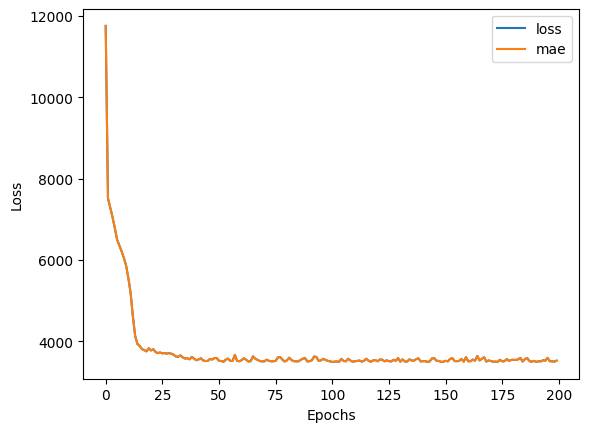

In [138]:
# Plot history (Also known as a loss curve or a training curve)
pd.DataFrame(history.history).plot()
plt.ylabel("Loss")
plt.xlabel("Epochs")

From this, it looks like our model's loss (and MAE) were both still decreasing (in our case, MAE and loss are the same, hence the lines in the plot overlap eachother).

What this tells us is the loss might go down if we try training it for longer.

> 🤔 **Question:** How long should you train for? 

> It depends on what problem you're working on. Sometimes training won't take very long, other times it'll take longer than you expect. A common method is to set your model training for a very long time (e.g. 1000's of epochs) but set it up with an [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) so it stops automatically when it stops improving. We'll see this in another module.

Let's train the same model as above for a little longer. We can do this but calling fit on it again.

 ## Preprocessing data (normalization and standardization)

A common practice when working with neural networks is to make sure all of the data you pass to them is in the range 0 to 1.

This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).

There is another process call **standardization** which converts all of your data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare your data for use with neural networks).

Knowing this, some of the major steps you'll take to preprocess your data for a neural network include:
* Turning all of your data to numbers (a neural network can't handle strings).
* Making sure your data is in the right shape (verifying input and output shapes).
* [**Feature scaling**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler):
    * Normalizing data (making sure all values are between 0 and 1). This is done by subtracting the minimum value then dividing by the maximum value minus the minmum. This is also referred to as min-max scaling.
    * Standardization (making sure all values have a mean of 0 and a variance of 1). This is done by substracting the mean value from the target feature and then dividing it by the standard deviation.
    * Which one should you use?
      * **With neural networks you'll tend to favour normalization** as they tend to prefer values between 0 and 1 (you'll see this espcially with image processing), however, you'll often find a neural network can perform pretty well with minimal feature scaling.

> 📖 **Resource:** For more on preprocessing data, I'd recommend reading the following resources:
* [Scikit-Learn's documentation on preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data).
* [Scale, Standardize or Normalize with Scikit-Learn by Jeff Hale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).

We've already turned our data into numbers using `get_dummies()`, let's see how we'd normalize it as well.

<Axes: ylabel='Frequency'>

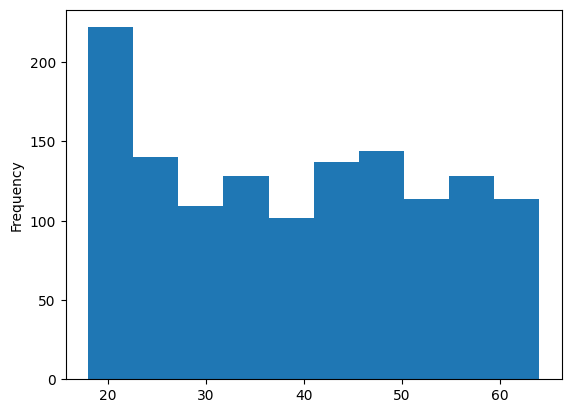

In [139]:
X["age"].plot(kind="hist")

<Axes: ylabel='Frequency'>

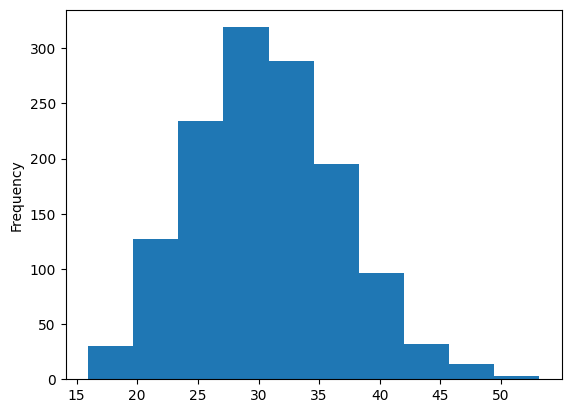

In [140]:
X["bmi"].plot(kind="hist")

In [142]:
X["children"].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataframe
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing transformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [152]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # Turn all values in these between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X and y values
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Buils our train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Fit the column transformer to our training data
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [153]:
# What does our data look like
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [160]:
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

In [162]:
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Our data is normalized and numerical, let's model it.

We'll use the same model as `insurance_model_2`.

In [163]:
# Build a neural network model to fit on our normalized data

In [169]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
insurance_model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["mae"])

# 3. Fit the model
insurance_model_3.fit(X_train_normal, y_train, epochs=200)

Epoch 1/200
34/34 [==============================] - 1s 5ms/step - loss: 13344.6797 - mae: 13344.6797
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 13337.7861 - mae: 13337.7861
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 13319.7559 - mae: 13319.7559
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 13280.0420 - mae: 13280.0420
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 13207.3623 - mae: 13207.3623
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 13090.4912 - mae: 13090.4912
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 12918.8916 - mae: 12918.8916
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 12682.2764 - mae: 12682.2764
Epoch 9/200
34/34 [==============================] - 0s 5ms/step - loss: 12370.3838 - mae: 12370.3838
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 11977.54

In [168]:
# Evaluate our insurance_model trained on normalized data
insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 3437.2786 - mae: 3437.2786


[3437.278564453125, 3437.278564453125]

From this we can see normalizing the data results in 10% less error using the same model than not normalizing the data.

This is **one of the main benefits of normalization: faster convergence time** (a fancy way of saying, your model gets to better results faster).

`insurance_model_2` may have eventually achieved the same results as `insurance_model_3` if we left it training for longer. 

Also, the results may change if we were to alter the architectures of the models, e.g. more hidden units per layer or more layers.

But since our main goal as neural network practitioners is to decrease the time between experiments, anything that helps us get better results sooner is a plus.

## 🛠 Exercises

We've a covered a whole lot pretty quickly.

So now it's time to have a **play around** with a few things and start to build up your intuition.

I emphasise the words play around because that's very important. Try a few things out, run the code and see what happens.

1. Create your own regression dataset (or make the one we created in "Create data to view and fit" bigger) and build fit a model to it.
2. Try building a neural network with 4 Dense layers and fitting it to your own regression dataset, how does it perform?
3. Try and improve the results we got on the insurance dataset, some things you might want to try include:
  * Building a larger model (how does one with 4 dense layers go?).
  * Increasing the number of units in each layer.
  * Lookup the documentation of [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and find out what the first parameter is, what happens if you increase it by 10x?
  * What happens if you train for longer (say 300 epochs instead of 200)? 
4. Import the [Boston pricing dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing/load_data) from TensorFlow [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) and model it.


## 📖 Extra curriculum

If you're looking for extra materials relating to this notebook, I'd check out the following:

* [MIT introduction deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) - gives a great overview of what's happening behind all of the code we're running.
* Reading: 1-hour of [Chapter 1 of Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielson - a great in-depth and hands-on example of the intuition behind neural networks.

To practice your regression modelling with TensorFlow, I'd also encourage you to look through [Lion Bridge's collection of datasets](https://lionbridge.ai/datasets/) or [Kaggle's datasets](https://www.kaggle.com/data), find a regression dataset which sparks your interest and try to model.

see the livk about **Scale, Standardize, or Normalize with Scikit-Learn**


https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
